# Predicting heart disease

In this notebook I will attempt to use Python libraries to create a model that predicts if a patient has heart disease.

I will take the following approach:
1. Define the problem
2. The data
3. Define the evaluation metric that means success
4. Decide which features of the given data should be focused on
5. Create the model
6. Experimentation with the model and data

## 1. Problem definition

"Given clinical parameters of a patient can the model predict whether or not they have heart disease" 

Since this sounds like a classification problem we will be using the Scikit-Learn algorithm to help us decide on the estimator

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

## 2. The data

This dataset comes from Kaggle ( https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci ) and it is based on the Cleveland data available in the UCI ML repository. Some changes in descriptions have been made by the author of this dataset

## 3. Evaluation

The goal is to reach around 95% accuracy at predicting whether or not the patient has heart disease 

## 4. Picking data features

Creating a way to easily get information about the data

**Create data dictionary** 

* age: age in years
* sex: sex (1 = male; 0 = female)
* cp: chest pain type

    -- Value 0: typical angina

    -- Value 1: atypical angina

    -- Value 2: non-anginal pain
  
    -- Value 3: asymptomatic
* trestbps: resting blood pressure (in mm Hg on admission to the hospital)
* chol: serum cholestoral in mg/dl
* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg: resting electrocardiographic results

    -- Value 0: normal

    -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

    -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach: maximum heart rate achieved
* exang: exercise induced angina (1 = yes; 0 = no)
* oldpeak = ST depression induced by exercise relative to rest
* slope: the slope of the peak exercise ST segment

    -- Value 0: upsloping

    -- Value 1: flat

    -- Value 2: downsloping
* ca: number of major vessels (0-3) colored by flourosopy
* thal: 0 = normal; 1 = fixed defect; 2 = reversable defect 
* condition: 0 = no disease, 1 = disease

In [159]:
# Getting the tools ready 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
# Pandas, Numpy and Matplotlib will be used for data analysis and manipulation

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

# Scikit-Learn will be used in order to create, fit and evaluate the model. 
# We are importing the models in accordance to Scikit-Learn algorithm cheat-sheet

## Loading the data

In [55]:
df = pd.read_csv("heart_cleveland_upload.csv")
df.shape

(297, 14)

## Data exploration (EDA)

1. What question(s) are we trying to answer
2. What kind of data do we have, is it of one type or not
3. What's missing from the data and how to deal with it
4. Where are the outliers and how do we deal with them
5. How can we add, change, remove features to get more from the data provided


In [56]:
df.rename(columns={"condition":"target"}, inplace=True)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [57]:
df["target"].value_counts(), print(f"There are {df['target'].value_counts().sum()} values in the target column")

There are 297 values in the target column


(0    160
 1    137
 Name: target, dtype: int64,
 None)

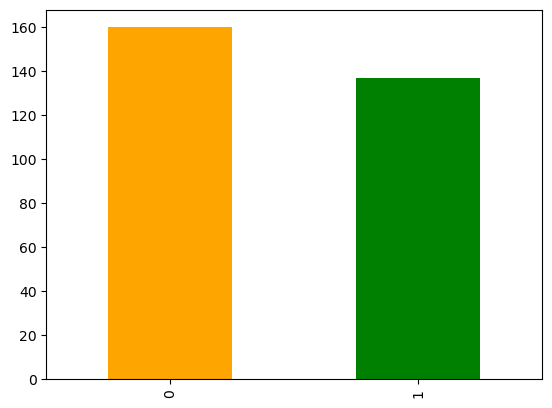

In [58]:
df["target"].value_counts().plot(kind="bar", color=["orange", "green"]);

In [59]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    int64  
 2   cp        297 non-null    int64  
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    int64  
 6   restecg   297 non-null    int64  
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    int64  
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    int64  
 11  ca        297 non-null    int64  
 12  thal      297 non-null    int64  
 13  target    297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


(None,
 age         0
 sex         0
 cp          0
 trestbps    0
 chol        0
 fbs         0
 restecg     0
 thalach     0
 exang       0
 oldpeak     0
 slope       0
 ca          0
 thal        0
 target      0
 dtype: int64)

There are no missing values in any of the columns making our job a little easier, since we don't have to deal with removing or supplementing any of it

### Heart Disease Frequency according to Sex

In [60]:
df["sex"].value_counts()

1    201
0     96
Name: sex, dtype: int64

Text(0, 0.5, 'Amounts')

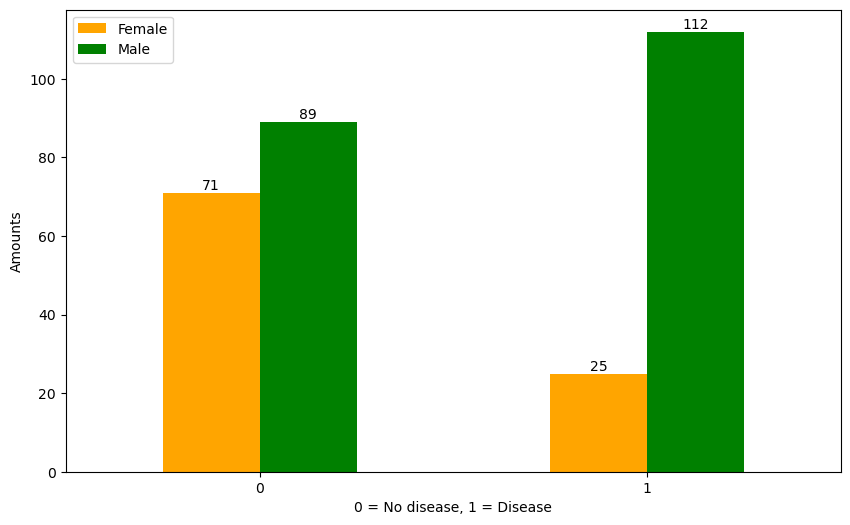

In [61]:
# Compare target column with sex column
fig, ax = plt.subplots()
pd.crosstab(df["target"], df["sex"]).plot(kind="bar", figsize=(10, 6), color=["orange", "green"], ax=ax)
for container in ax.containers:
    ax.bar_label(container)
ax.legend(["Female", "Male"])
plt.xticks(rotation=0)
plt.xlabel("0 = No disease, 1 = Disease")
plt.ylabel("Amounts")

### Age vs. Maximum Heart Rate for Heart Disease

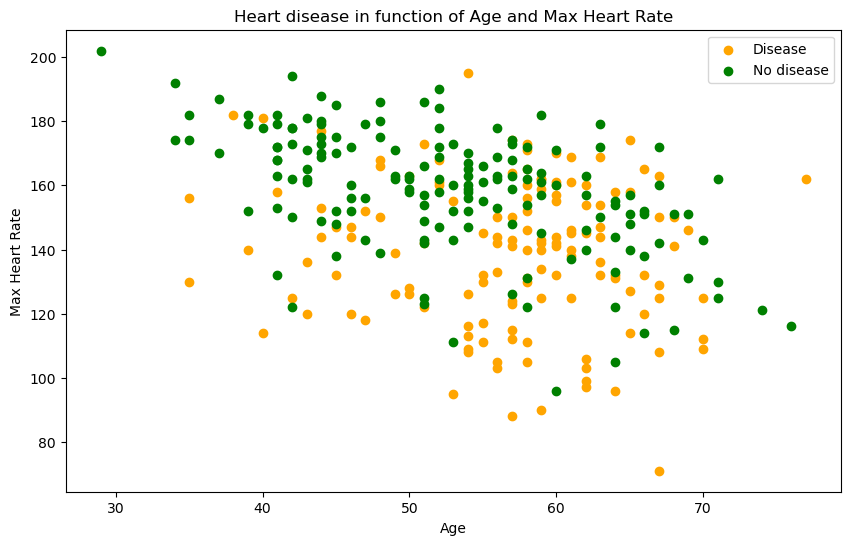

In [62]:
plt.figure(figsize=(10, 6))

plt.scatter(df["age"][df["target"]==1], df["thalach"][df["target"]==1], c="orange")
plt.scatter(df["age"][df["target"]==0], df["thalach"][df["target"]==0], c="green")
plt.title("Heart disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Disease", "No disease"]);

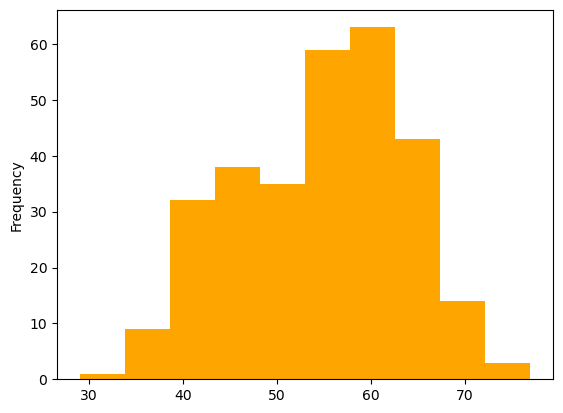

In [63]:
df["age"].plot(kind="hist", color="orange");

### Heart Disease Frequency per Chest Pain type

cp: chest pain type

    -- Value 0: typical angina

    -- Value 1: atypical angina

    -- Value 2: non-anginal pain
  
    -- Value 3: asymptomatic

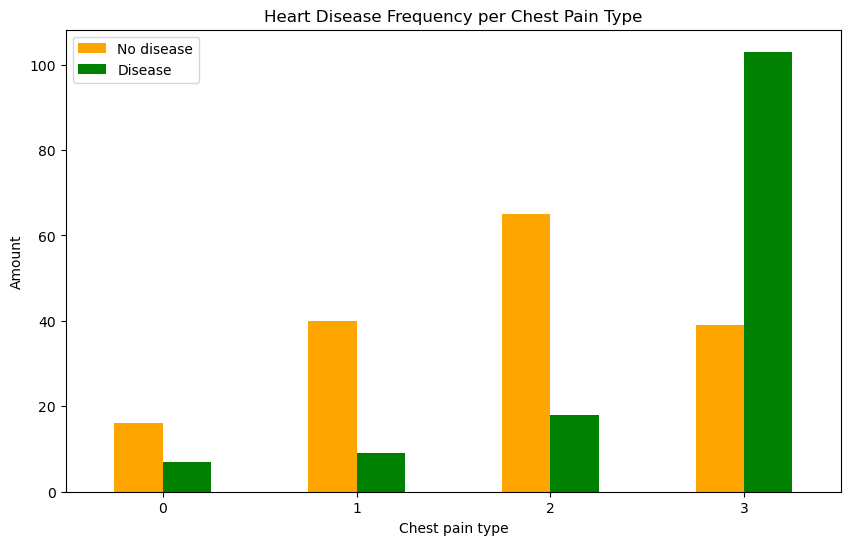

In [64]:
pd.crosstab(df["cp"], df["target"]).plot(kind="bar", figsize=(10, 6), color=["orange", "green"])
plt.title("Heart Disease Frequency per Chest Pain Type")
plt.xlabel("Chest pain type")
plt.ylabel("Amount")
plt.legend(["No disease", "Disease"])
plt.xticks(rotation=0);
# I believe that either the original dataset was wrong 
# or that this one is somehow inverted and 0 means that the patient has heart disease...

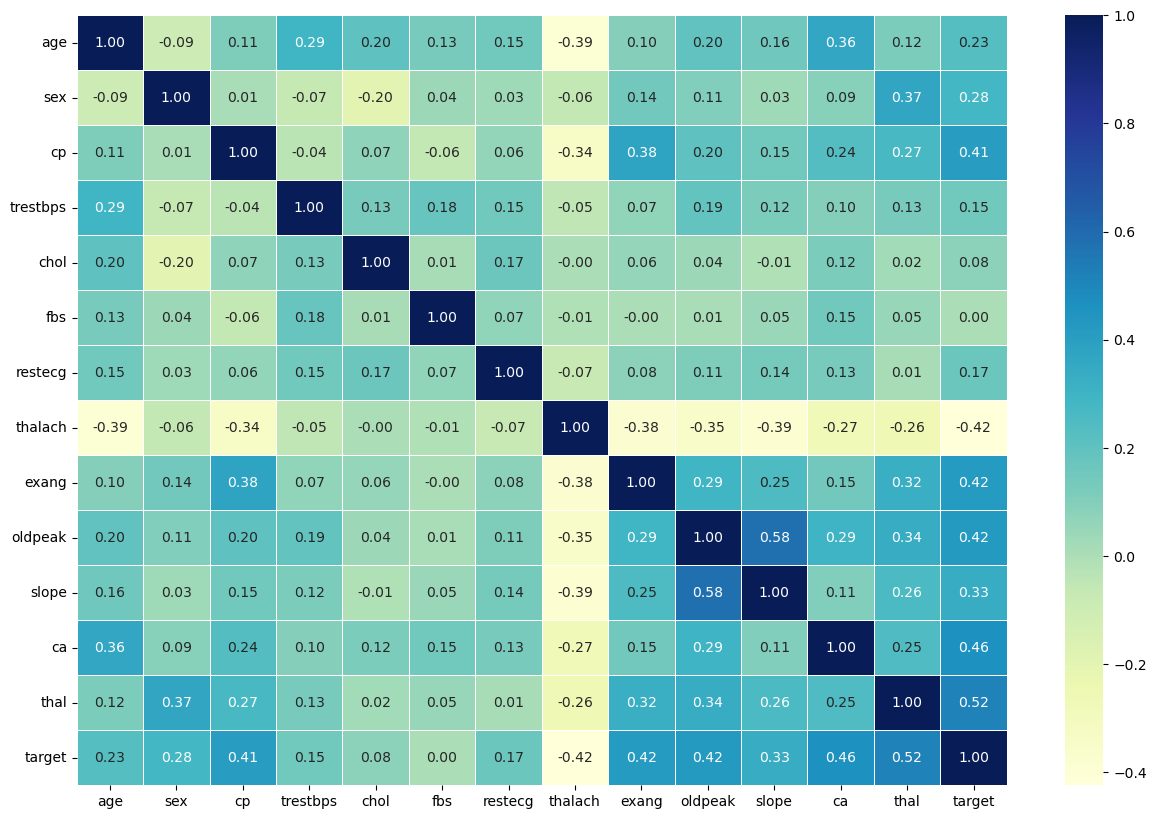

In [65]:
# Making a correlation matrix
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")
plt.yticks(rotation=0);

## 5. Modelling

In [66]:
# Splitting data into X and y
X = df.drop("target", axis=1)
y = df["target"]

# Splitting the data into training and test sets
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

We are going to try 3 different machine learning models
1. Logistic Regression
2. K-Nearest Neighbors Classifier
3. Random Forrest Classifier 

In [67]:
# Create a models dictionary

models = {
    "LogisticRegression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

# Create a function which fits models and scores them

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """This function fits models from the models dictionary and then evaluates them, returning each models score
    models: dictionary consisting on all models that will be used
    X_train: training data (no labels)
    X_test: testing data(no labels)
    y_train: training labels
    y_test: testing lables"""

    # set random seed so the results are reproducible
    np.random.seed(42)
    
    model_scores = {}
    for name, model in models.items():
        # It's time to fit the models with our training data and lables
        model.fit(X_train, y_train)
        # Here we append the model_scores dict with the scores for each model
        model_scores[name] = model.score(X_test, y_test)

    return model_scores


In [68]:
model_scores = fit_and_score(
    models= models,
    X_train= X_train,
    X_test= X_test,
    y_train= y_train,
    y_test= y_test
)

model_scores

/Users/aleksanderciesielski/opt/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'LogisticRegression': 0.8,
 'KNN': 0.5888888888888889,
 'RandomForestClassifier': 0.8111111111111111}

## Model Comparison

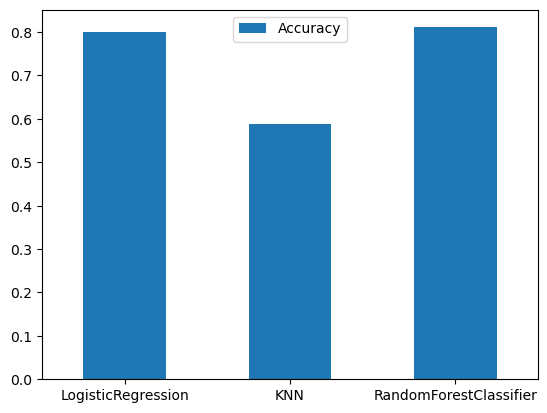

In [69]:
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
model_compare.T.plot.bar()
plt.xticks(rotation=0);

Now that we have accuracy of the base models it's time to work on tuning the most promising ones

We'll focus on the following:
1. Hyperparameter tuning
2. Feature importance
3. Confusion matrix
4. Cross-validation
5. Precision
6. Recall
7. F1 score
8. Classification report
9. Area Under Curve (AUC)

## Hyperparameter Tuning 

In [70]:
# Starting with KNN Classifier

train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different neighbors and fit different models 
for i in neighbors:
    knn.set_params(n_neighbors=i)
    knn.fit(X_train, y_train)

    # Update train_scores and test_scores lists 
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))


In [71]:
train_scores

[1.0,
 0.782608695652174,
 0.782608695652174,
 0.7536231884057971,
 0.748792270531401,
 0.7584541062801933,
 0.7439613526570048,
 0.7391304347826086,
 0.714975845410628,
 0.7198067632850241,
 0.714975845410628,
 0.7246376811594203,
 0.7053140096618358,
 0.7294685990338164,
 0.7294685990338164,
 0.714975845410628,
 0.7101449275362319,
 0.7294685990338164,
 0.714975845410628,
 0.7198067632850241]

In [72]:
test_scores

[0.5444444444444444,
 0.5888888888888889,
 0.6,
 0.5555555555555556,
 0.5888888888888889,
 0.5777777777777777,
 0.6222222222222222,
 0.5888888888888889,
 0.6333333333333333,
 0.6333333333333333,
 0.6666666666666666,
 0.6222222222222222,
 0.6333333333333333,
 0.6555555555555556,
 0.6333333333333333,
 0.6555555555555556,
 0.6444444444444445,
 0.6777777777777778,
 0.6666666666666666,
 0.6444444444444445]

Maximum KNN score on test data is 67.78%


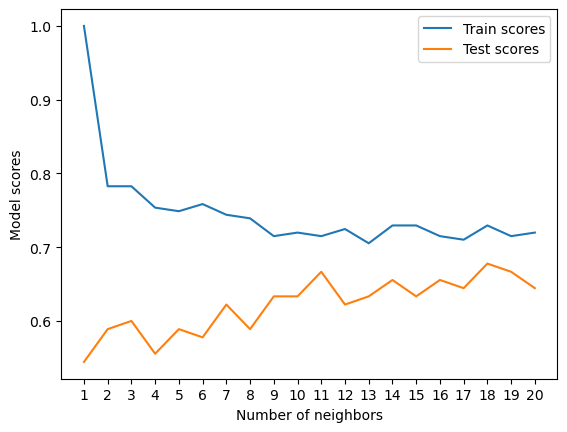

In [73]:
plt.plot(neighbors, train_scores, label="Train scores")
plt.plot(neighbors, test_scores, label="Test scores")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model scores")
plt.legend()

print(f"Maximum KNN score on test data is {max(test_scores)*100:.2f}%")

The results made me decide on not pursuing the KNN Classifier

## Hyperparameter tuning with RandomizedSearchCV

I'll focus on tuning:
 * LogisticRegression()
 * RandomForestClassifier()

In [87]:
# Starting with a grid of parameters for LogisticRegression()
log_reg_grid = {
    "C": np.logspace(-4, 4, 30),
    "solver": ["liblinear", "lbfgs"]
}

# Now hyperparameter grid for RandomForestClassifier()
rand_for_grid = {
    "n_estimators": np.arange(10, 1000, 50),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2)
}

rs_scores = {}

In [88]:
# Starting with LogisticRegression

np.random.seed(42)

rs_log_reg = RandomizedSearchCV(
    estimator= LogisticRegression(), 
    param_distributions= log_reg_grid,
    cv= 5,
    n_iter= 20,
    verbose= True
)

# Fitting random hyperparameter search model for LogisticRegression

rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/aleksanderciesielski/opt/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aleksanderciesielski/opt/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                                        'solver': ['liblinear', 'lbfgs']},
                   verbose=True)

In [89]:
rs_log_reg.best_params_

{'solver': 'lbfgs', 'C': 2.592943797404667}

In [90]:
rs_scores["LogisticRegression"] = rs_log_reg.score(X_test, y_test)

In [91]:
# Now it's time to tune RandomForestClassifier

np.random.seed(42)

rs_rand_for = RandomizedSearchCV(
    estimator= RandomForestClassifier(),
    param_distributions= rand_for_grid,
    cv= 5,
    n_iter= 20,
    verbose= True
)

rs_rand_for.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [92]:
rs_rand_for.best_params_

{'n_estimators': 460,
 'min_samples_split': 6,
 'min_samples_leaf': 9,
 'max_depth': None}

In [93]:
rs_scores["RandomForestClassifier"] = rs_rand_for.score(X_test, y_test)

In [94]:
print(f"Default hyperparameter scores: {model_scores}\n\n RandomizedSearchCV scores: {rs_scores}")

Default hyperparameter scores: {'LogisticRegression': 0.8, 'KNN': 0.5888888888888889, 'RandomForestClassifier': 0.8111111111111111}

 RandomizedSearchCV scores: {'LogisticRegression': 0.7888888888888889, 'RandomForestClassifier': 0.8111111111111111}


Based on the best params we got these scores - LogisticRegression fares worse than on default settings, RandomForestClassifier did exactly as well on tuned and untuned hyperparameters

## Hyperparameter tuning using GridSearchCV

Now we will give both of those models a chance and compare the scores

In [100]:
gs_scores = {}

gs_log_reg = GridSearchCV(
    estimator= LogisticRegression(),
    param_grid= log_reg_grid,
    cv=5,
    verbose= True
)

gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aleksanderciesielski/opt/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aleksanderciesielski/opt/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear', 'lbfgs']},
             verbose=True)

In [101]:
gs_log_reg.best_params_

{'C': 0.05736152510448681, 'solver': 'liblinear'}

In [102]:
gs_scores["LogisticRegression"] = gs_log_reg.score(X_test, y_test)

For GridSearchCV to work on RandomForestClassifier we have to edit the param_grid, since in it's current state it would have to go through about 36000 different fits

In [104]:
rand_for_grid

{'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
        660, 710, 760, 810, 860, 910, 960]),
 'max_depth': [None, 3, 5, 10],
 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])}

In [107]:
# These changes result in only 5400 fits, which is manageable (on my computer in about 16 minutes). Time to get a cup of coffee

gs_rand_for_grid = {
    "n_estimators": np.arange(250, 700, 50),
    "max_depth": [None, 3, 5],
    "min_samples_split": np.arange(5, 15, 2),
    "min_samples_leaf": np.arange(4, 20, 2)
}

In [106]:
gs_rand_for = GridSearchCV(
    estimator= RandomForestClassifier(),
    param_grid= gs_rand_for_grid,
    cv= 5,
    verbose= True
)

gs_rand_for.fit(X_train, y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 5],
                         'min_samples_leaf': array([ 4,  6,  8, 10, 12, 14, 16, 18]),
                         'min_samples_split': array([ 5,  7,  9, 11, 13]),
                         'n_estimators': array([250, 300, 350, 400, 450, 500, 550, 600, 650])},
             verbose=True)

In [108]:
gs_rand_for.best_params_

{'max_depth': 5,
 'min_samples_leaf': 18,
 'min_samples_split': 9,
 'n_estimators': 250}

In [109]:
gs_scores["RandomForestClassifier"] = gs_rand_for.score(X_test, y_test)

In [112]:
print(f"Default hyperparameter scores: {model_scores}\n\n GridSearchCV scores: {gs_scores}\n\n")
print(f"RandomizedSearchCV hyperparameter scores: {rs_scores}\n\n RandomizedSearchCV scores: {gs_scores}")

Default hyperparameter scores: {'LogisticRegression': 0.8, 'KNN': 0.5888888888888889, 'RandomForestClassifier': 0.8111111111111111}

 GridSearchCV scores: {'LogisticRegression': 0.7666666666666667, 'RandomForestClassifier': 0.8}


RandomizedSearchCV hyperparameter scores: {'LogisticRegression': 0.7888888888888889, 'RandomForestClassifier': 0.8111111111111111}

 RandomizedSearchCV scores: {'LogisticRegression': 0.7666666666666667, 'RandomForestClassifier': 0.8}


Unexpectedly in this case both models did worse than on both the default and RandomizedSearchCV settings. We'll get back to that later, after going through the whole workflow.

## Evaluting our tuned machine leargning models

* ROC Curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score

It would be best to use cross-validation whenever possible. We will evaluate the gs_log_reg and the rs_rand_for models.

In [178]:
# We start of by making predictions for the Logistic Regression
y_log_reg_preds = gs_log_reg.predict_proba(X_test)[::,1]
y_rand_for_preds = rs_rand_for.predict_proba(X_test)[::,1]
evaluated_models = {
    "LogisticRegression": gs_log_reg, 
    "RandomForestClassifier": rs_rand_for
}

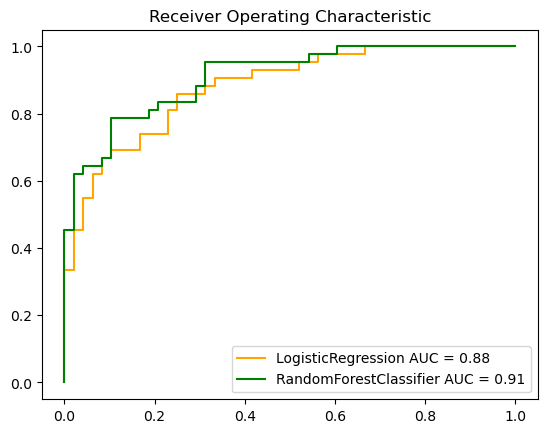

In [164]:
# Plotting the ROC Curve and calculating the AUC metric
lr_fpr, lr_tpr, lr_threshold = roc_curve(y_test, y_log_reg_preds)
rfc_fpr, rfc_tpr, rfc_threshold = roc_curve(y_test, y_rand_for_preds)
log_reg_roc_auc = auc(lr_fpr, lr_tpr)
rand_for_roc_auc = auc(rfc_fpr, rfc_tpr)


fig, ax = plt.subplots()
plt.title("Receiver Operating Characteristic")
plt.plot(lr_fpr, lr_tpr, label="LogisticRegression AUC = %0.2f"% log_reg_roc_auc, color="orange")
plt.plot(rfc_fpr, rfc_tpr, label="RandomForestClassifier AUC = %0.2f"% rand_for_roc_auc, color="green")
plt.legend(loc= "lower right")



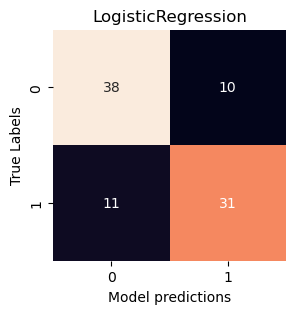

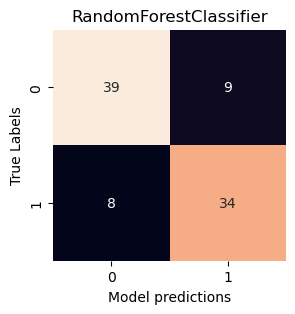

In [194]:
# Confusion matrix
def plot_conf_mat(y_test, y_preds, name):
    """Plots a confusion matrix using Seaborn's heatmap()"""
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds), annot= True, cbar= False)
    plt.title(name)
    plt.xlabel("Model predictions")
    plt.ylabel("True Labels")


for name, model in evaluated_models.items():
    plot_conf_mat(y_test, model.predict(X_test), name)


Now that we have ROC curves, AUC metrics and confusion matrices we can focus on classification report as well as cross-validated precision, recall and F1-score

In [199]:
# This classification report is done only on the test data, forward we will attempt to cross-validate precision, recall and F1

for name, model in evaluated_models.items():
    print(f"Classification report for {name}:\n\n{classification_report(y_test, model.predict(X_test))}")

Classification report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.78      0.79      0.78        48
           1       0.76      0.74      0.75        42

    accuracy                           0.77        90
   macro avg       0.77      0.76      0.77        90
weighted avg       0.77      0.77      0.77        90

Classification report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        48
           1       0.79      0.81      0.80        42

    accuracy                           0.81        90
   macro avg       0.81      0.81      0.81        90
weighted avg       0.81      0.81      0.81        90



## Calculate evaluation metrics using cross-validation

We're going to calculate the same metrics as above using `cross_val_score()`

In [202]:
# Recreate a new classifiers with the best params that we found before
print(f"LogisticRegression: {gs_log_reg.best_params_}\nRandomForestClassifier: {rs_rand_for.best_params_}")

LogisticRegression: {'C': 0.05736152510448681, 'solver': 'liblinear'}
RandomForestClassifier: {'n_estimators': 460, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_depth': None}


In [239]:
log_reg_clf = LogisticRegression(
    C= 0.05736152510448681,
    solver= "liblinear"
)

rand_for_clf = RandomForestClassifier(
    n_estimators= 460,
    min_samples_split= 6,
    min_samples_leaf= 9,
    max_depth= None
)

cv_models = ["LogisticRegression", "RandomForestClassifier"]

In [233]:
# Cross-validated accuracies

cv_acc = {
    "LogisticRegression": np.mean(cross_val_score(log_reg_clf, X, y, cv= 5, scoring= "accuracy")),
    "RandomForestClassifier": np.mean(cross_val_score(rand_for_clf, X, y, cv= 5, scoring= "accuracy"))
}
cv_acc 

{'LogisticRegression': 0.8319774011299437,
 'RandomForestClassifier': 0.7780225988700564}

Oddily enough, when cross-validated the `LogisticRegression()` model seems to be doing better

In [234]:
# Cross-validated precision

cv_precision = {
    "LogisticRegression": np.mean(cross_val_score(log_reg_clf, X, y, cv= 5, scoring= "precision")),
    "RandomForestClassifier": np.mean(cross_val_score(rand_for_clf, X, y, cv= 5, scoring= "precision"))
}
cv_precision 

{'LogisticRegression': 0.8717492163009405,
 'RandomForestClassifier': 0.8303029444580036}

In [236]:
# Cross-validated recall

cv_recall = {
    "LogisticRegression": np.mean(cross_val_score(log_reg_clf, X, y, cv= 5, scoring= "recall")),
    "RandomForestClassifier": np.mean(cross_val_score(rand_for_clf, X, y, cv= 5, scoring= "recall"))
}
cv_recall 


{'LogisticRegression': 0.7542328042328041,
 'RandomForestClassifier': 0.7333333333333334}

In [237]:
# Cross-validated F1-score

cv_f1 = {
    "LogisticRegression": np.mean(cross_val_score(log_reg_clf, X, y, cv= 5, scoring= "f1")),
    "RandomForestClassifier": np.mean(cross_val_score(rand_for_clf, X, y, cv= 5, scoring= "f1"))
}
cv_f1

{'LogisticRegression': 0.7876874697629415,
 'RandomForestClassifier': 0.720959419793444}

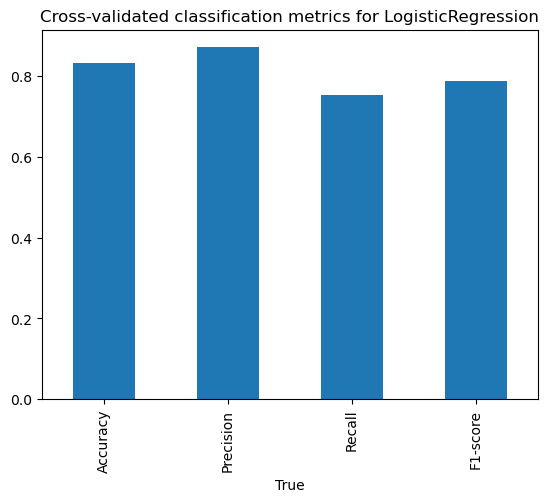

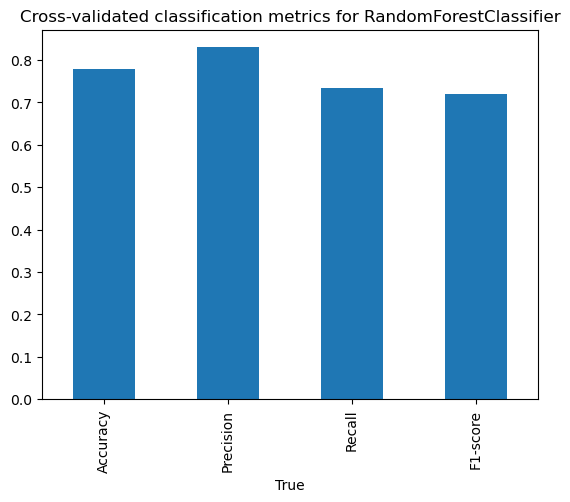

In [246]:
# Visualize cross-validated metrics
cv_metrics = {}
for model in cv_models:
    cv_metrics[model] = pd.DataFrame({
        "Accuracy": cv_acc[model],
        "Precision": cv_precision[model],
        "Recall": cv_recall[model],
        "F1-score": cv_f1[model]}, index=[0])

for name, metric in cv_metrics.items():
    metric.T.plot.bar(title=f"Cross-validated classification metrics for {name}", legend= False, )
    
